In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import RealAmplitudes, EfficientSU2
from qiskit.quantum_info import Statevector
from qiskit.opflow import Z, MatrixOp

from surfer.gradient import ReverseGradient
from surfer.qfi import ReverseQFI

### QGT time

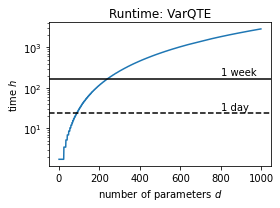

In [63]:
circuits_per_job = 300
jobtime = 19 + 2 / 50 * circuits_per_job # in seconds
num_parameters = np.arange(1, 1000)
num_circuits = num_parameters * (num_parameters + 1) / 2
num_jobs = np.ceil(num_circuits / circuits_per_job)
timesteps = 200

times = num_jobs * jobtime * timesteps

plt.figure(figsize=(4,3))
plt.semilogy(num_parameters, times / 3600)
# plt.axhline(1, color="k", ls=":")
plt.axhline(24, color="k", ls="--")
plt.axhline(24 * 7, color="k", ls="-")
plt.title("Runtime: VarQTE")
plt.xlabel("number of parameters $d$")
plt.ylabel("time $h$")
# plt.text(800, 1.2, "1 hour")
plt.text(800, 1.2 * 24, "1 day")
plt.text(800, 1.2 * 24 * 7, "1 week")
plt.tight_layout()
plt.savefig("runtime.pdf")

In [64]:
200 * 6094

1218800

In [67]:
circuits_per_job = 300
jobtime = 19 + 2 / 50 * circuits_per_job # in seconds
num_circuits = 1.22e6
num_jobs = np.ceil(num_circuits / circuits_per_job)
# timesteps = 200

print(num_jobs * jobtime / 3600)

35.021388888888886


In [69]:
circuits_per_job = 300
jobtime = 19 + 2 / 50 * circuits_per_job # in seconds
num_circuits = 12e3
num_jobs = np.ceil(num_circuits / circuits_per_job)
# timesteps = 200

print(num_jobs * jobtime / 60)

20.666666666666668


### Approximation errors

In [2]:
ansatz = RealAmplitudes(2, reps=3)
theta = np.arange(1, 1 + ansatz.num_parameters) / ansatz.num_parameters
direction = np.ones_like(theta)
eps = np.linspace(0, 1, num=100)
norms = [np.linalg.norm(e_i * direction) for e_i in eps]

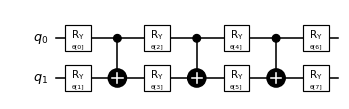

In [3]:
plt.figure()
ax = plt.axes()
ansatz.decompose().draw("mpl", style="bw", ax=ax)
# plt.tight_layout()
# plt.savefig("realamplitudes_n2_r3.pdf")

In [4]:
from qiskit.quantum_info import SparsePauliOp

In [16]:
n = 2

local_proj = SparsePauliOp.from_sparse_list(
    [("Z", [i], 0.5 / n) for i in range(n)] 
    + [("I", [i], 0.5 / n) for i in range(n)],
    n
)

In [30]:
def local_infidelity(ansatz, values1, values2):
    circuit = ansatz.bind_parameters(values1)
    circuit.compose(ansatz.bind_parameters(values2).inverse(), inplace=True)
    
    inner = Statevector(circuit).expectation_value(local_proj)
    return 1 - np.abs(inner) ** 2

In [18]:
def infidelity(ansatz, values1, values2):
    circuit1 = ansatz.bind_parameters(values1)
    circuit2 = ansatz.bind_parameters(values2)
    
    inner = np.conj(Statevector(circuit1)).T.dot(Statevector(circuit2))
    return 1 - np.abs(inner) ** 2

In [19]:
def arccos(ansatz, values1, values2):
    circuit1 = ansatz.bind_parameters(values1)
    circuit2 = ansatz.bind_parameters(values2)
    
    inner = np.conj(Statevector(circuit1)).T.dot(Statevector(circuit2))
    return np.arccos(np.abs(inner)) ** 2

In [20]:
def metric(ansatz, values1, values2, qgt=None):
    if qgt is None:
        qgt = ReverseQFI().compute(ansatz, values2) / 4
    return (values2 - values1).dot(qgt.dot(values2 - values1))

In [21]:
infidelities = np.array([infidelity(ansatz, theta, theta + e * direction) for e in eps])

In [22]:
arcosses = [arccos(ansatz, theta, theta + e * direction) for e in eps]

<ipython-input-19-794084cb13c6>:6: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(np.abs(inner)) ** 2


In [23]:
metrics = [metric(ansatz, theta, theta + e * direction) for e in eps]

In [31]:
local_infidelities = np.array([local_infidelity(ansatz, theta, theta + e * direction) for e in eps])

In [11]:
def sqrt_expansion(x, n):
    approx = 1
    kfac = 1
    alpha = 1/2
    for k in range(1, n + 1):
        print(alpha, kfac, (-1) ** k * alpha / kfac)
        approx += (-x) ** k * alpha / kfac
        kfac = kfac * (k + 1)
        alpha = alpha * (1/2 - k)

    return approx

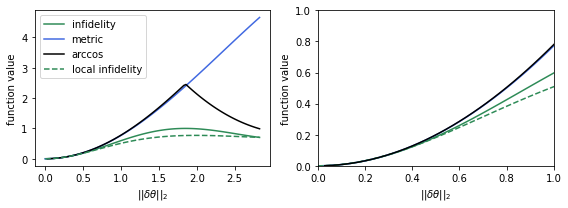

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

axs[0].plot(norms, infidelities, color="seagreen", label="infidelity")
# axs[0].plot(norms, np.arccos(sqrt_expansion(infidelities, 20)) ** 2, color="seagreen", label="fidelity")
axs[0].plot(norms, metrics, color="royalblue", label="metric")
axs[0].plot(norms, arcosses, color="k", label="arccos")
axs[0].plot(norms, local_infidelities, color="seagreen", ls="--", label="local infidelity")
axs[0].legend(loc="best")
axs[0].set_ylabel("function value") 
axs[0].set_xlabel(r"$||\delta\theta||_2$")

axs[1].plot(norms, infidelities, color="seagreen")
axs[1].plot(norms, metrics, color="royalblue")
axs[1].plot(norms, local_infidelities, color="seagreen", ls="--", label="local infidelity")
axs[1].plot(norms, arcosses, color="k")
axs[1].set_ylabel("function value")
axs[1].set_xlabel(r"$||\delta\theta||_2$")
axs[1].set_xlim(0, 1)
axs[1].set_ylim(0, 1)

plt.tight_layout()
# plt.savefig("distance_metrics.pdf")

### Minimizing the loss function

In [34]:
th = Parameter("th")
circuit = QuantumCircuit(1)
circuit.ry(th, 0)

H = Z
dt = 0.01

value = np.array([1])
energy_gradient = 0.5 * ReverseGradient().compute(H, circuit, value)

In [35]:
energy_gradient

array([-0.42073549])

In [23]:
def loss(x, norm):
    return np.dot(energy_gradient, x) + 1 / (2 * dt) * norm(circuit, value, value + x)

In [24]:
def fid_norm(x, norm_factor=1, local=False):
    if local:
        eval_infid = local_infidelity
    else:
        eval_infid = infidelity
    return np.dot(energy_gradient, x) + 1 / (2 * dt) * eval_infid(circuit, value, value + x) * (1 + norm_factor * np.linalg.norm(x) ** 2)

In [47]:
eps = np.linspace(-10, 10, num=200)
fidelity_losses = [loss(e_i, infidelity) for e_i in eps]

In [48]:
fidnorm_losses = [fid_norm(e_i) for e_i in eps]

In [49]:
fidnorm02_losses = [fid_norm(e_i, 0.2) for e_i in eps]
fidnorm015_losses = [fid_norm(e_i, 0.15) for e_i in eps]

In [50]:
fidnorm05_losses = [fid_norm(e_i, 0.5) for e_i in eps]
fidnorm2_losses = [fid_norm(e_i, 2) for e_i in eps]

In [51]:
fidnorm10_losses = [fid_norm(e_i, 10) for e_i in eps]

In [52]:
arccos_losses = [loss(e_i, arccos) for e_i in eps]

In [53]:
metric_losses = [loss(e_i, metric) for e_i in eps]

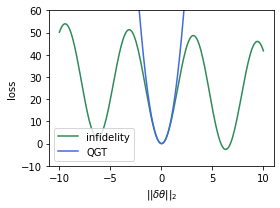

In [62]:
plt.figure(figsize=(4, 3))
plt.plot(eps, fidelity_losses, color="seagreen", alpha=1, label="infidelity")
# plt.plot(eps, arccos_losses, color="k", label="arccos")
plt.plot(eps, metric_losses, color="royalblue", label="QGT")
plt.legend(loc="best")
# plt.xlim(-20, 20)
plt.ylim(-10, 60)
plt.xlabel(r"$||\delta\theta||_2$")
plt.ylabel("loss")
plt.tight_layout()
plt.savefig("fid_vs_qgt.pdf")

(-10.0, 50.0)

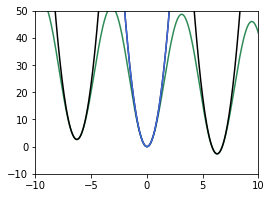

In [43]:
plt.figure(figsize=(4, 3))
plt.plot(eps, fidelity_losses, color="seagreen", alpha=1, label="fidelity")
# plt.plot(eps, fidnorm_losses, color="#58A279", alpha=1)
# plt.plot(eps, fidnorm2_losses, color="#ABD1BC", alpha=1)

plt.plot(eps, arccos_losses, color="k", label="arccos")
plt.plot(eps, metric_losses, color="royalblue", label="metric")
plt.xlim(-10, 10)
plt.ylim(-10, 50)

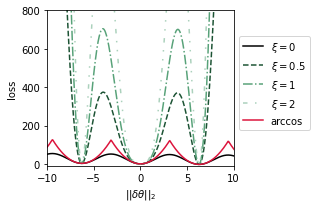

In [48]:
ddd = (0, (3, 5, 1, 5, 1, 5))

plt.figure(figsize=(4.5, 3))
plt.plot(eps, fidelity_losses, color="k", alpha=1, label=r"$\xi = 0$")
plt.plot(eps, fidnorm05_losses, color="#1C5334", alpha=1, ls="--", label=r"$\xi = 0.5$")
plt.plot(eps, fidnorm_losses, color="#58A279", alpha=1, ls="-.", label=r"$\xi = 1$")
plt.plot(eps, fidnorm2_losses, color="#ABD1BC", alpha=1, ls=ddd, label=r"$\xi = 2$")
# plt.plot(eps, fidnorm10_losses, color="grey", alpha=1, ls=":", label=r"$\xi = 10$")
plt.plot(eps, arccos_losses, color="crimson", label="arccos")
plt.legend(loc="best", bbox_to_anchor=(1, 0.2))

# plt.plot(eps, arccos_losses, color="k")
# plt.plot(eps, metric_losses, color="royalblue")
plt.xlim(-10, 10)
plt.ylim(-10, 800)
plt.xlabel(r"$||\delta\theta||_2$")
plt.ylabel("loss")
plt.tight_layout()
plt.savefig("loss_normalizations.pdf")

Text(0, 0.5, 'loss')

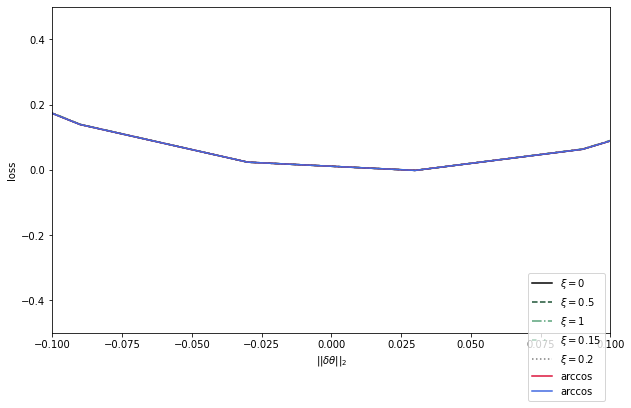

In [64]:
ddd = (0, (3, 5, 1, 5, 1, 5))

plt.figure(figsize=(10, 6))
plt.plot(eps, fidelity_losses, color="k", alpha=1, label=r"$\xi = 0$")
plt.plot(eps, fidnorm05_losses, color="#1C5334", alpha=1, ls="--", label=r"$\xi = 0.5$")
plt.plot(eps, fidnorm_losses, color="#58A279", alpha=1, ls="-.", label=r"$\xi = 1$")
plt.plot(eps, fidnorm015_losses, color="#ABD1BC", alpha=1, ls=ddd, label=r"$\xi = 0.15$")
plt.plot(eps, fidnorm02_losses, color="grey", alpha=1, ls=":", label=r"$\xi = 0.2$")
plt.plot(eps, arccos_losses, color="crimson", label="arccos")
plt.plot(eps, metric_losses, color="royalblue", label="arccos")
plt.legend(loc="best", bbox_to_anchor=(1, 0.2))

# plt.plot(eps, arccos_losses, color="k")
# plt.plot(eps, metric_losses, color="royalblue")
plt.xlim(-0.1, 0.1)
plt.ylim(-0.5, 0.5)
plt.xlabel(r"$||\delta\theta||_2$")
plt.ylabel("loss")
# plt.savefig("loss_normalizations.pdf")

### Local v Global

In [50]:
n = 3
circuit = EfficientSU2(n, reps=1, entanglement="pairwise")
point1 = np.random.random(circuit.num_parameters)
point2 = np.random.random(circuit.num_parameters)

H = SparsePauliOp.from_sparse_list(
    [(interaction, [i, i + 1], 0.25) for i in range(n - 1) for interaction in ["XX", "YY", "ZZ"]]
    + [("Z", [i], -1) for i in range(n)], 
    num_qubits=3
)
dt = 0.01

# value = np.array([1])
energy_gradient = 0.5 * ReverseGradient().compute(H, circuit, point1)
energy_gradient

array([ 0.73350146,  0.45071692,  0.37733451, -0.14221901, -0.1070206 ,
       -0.21084246,  0.35388868,  0.26309187,  0.13587919, -0.02534657,
        0.0314187 , -0.00607214])

In [51]:
def loss(x, norm):
    return np.dot(energy_gradient, x) + 1 / (2 * dt) * norm(circuit, point1, point1 + x)

In [52]:
eps = np.linspace(0, 1, num=200)

In [53]:
fidelity_losses = [loss(e_i * (point2 - point1), infidelity) for e_i in eps]

In [54]:
local_fidelity_losses = [loss(e_i * (point2 - point1), local_infidelity) for e_i in eps]

In [55]:
metric_losses = [loss(e_i * (point2 - point1), metric) for e_i in eps]

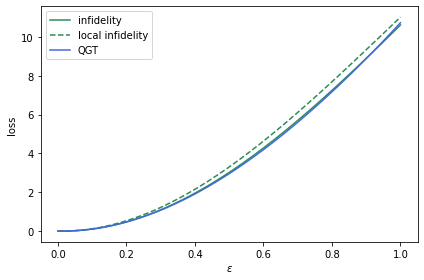

In [58]:
# plt.figure(figsize=(4, 3))
plt.plot(eps, fidelity_losses, color="seagreen", alpha=1, label="infidelity")
plt.plot(eps, local_fidelity_losses, color="seagreen", alpha=1, ls="--", label="local infidelity")
# plt.plot(eps, arccos_losses, color="k", label="arccos")
plt.plot(eps, metric_losses, color="royalblue", label="QGT")
plt.legend(loc="best")
# plt.xlim(-20, 20)
# plt.ylim(-10, 60)
plt.xlabel(r"$\epsilon$")
plt.ylabel("loss")
plt.tight_layout()
plt.savefig("fid_vs_qgt.pdf")

In [52]:
from functools import partial
from qiskit.algorithms.optimizers import GradientDescent
    
gd = GradientDescent(maxiter=100, learning_rate=0.01)

In [47]:
qgt = ReverseQFI().compute(circuit, value) / 4

In [49]:
def metric_loss(x):
    return energy_gradient.dot(x) + 0.5 / dt * x.dot(qgt.dot(x))

In [35]:
x0 = np.array([0.01])
result = gd.minimize(partial(fid_norm, norm_factor=0), x0)

In [58]:
losses = []
xs = []
def store_losses(*args):
    xs.append(args[1])
    losses.append(args[2])
    
gd.callback = store_losses

In [59]:
x0 = np.array([0.01])
result = gd.minimize(metric_loss, x0)

In [63]:
def selfconsistent(x):
    if isinstance(x, list):
        return [selfconsistent(x_i) for x_i in x]
    
    return energy_gradient.dot(x)

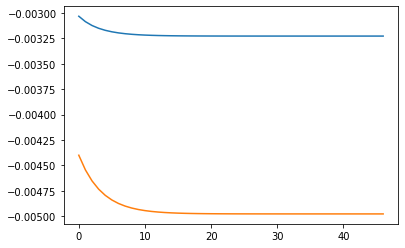

In [64]:
plt.plot(losses)
plt.plot(selfconsistent(xs))

(-40.0, 800.0)

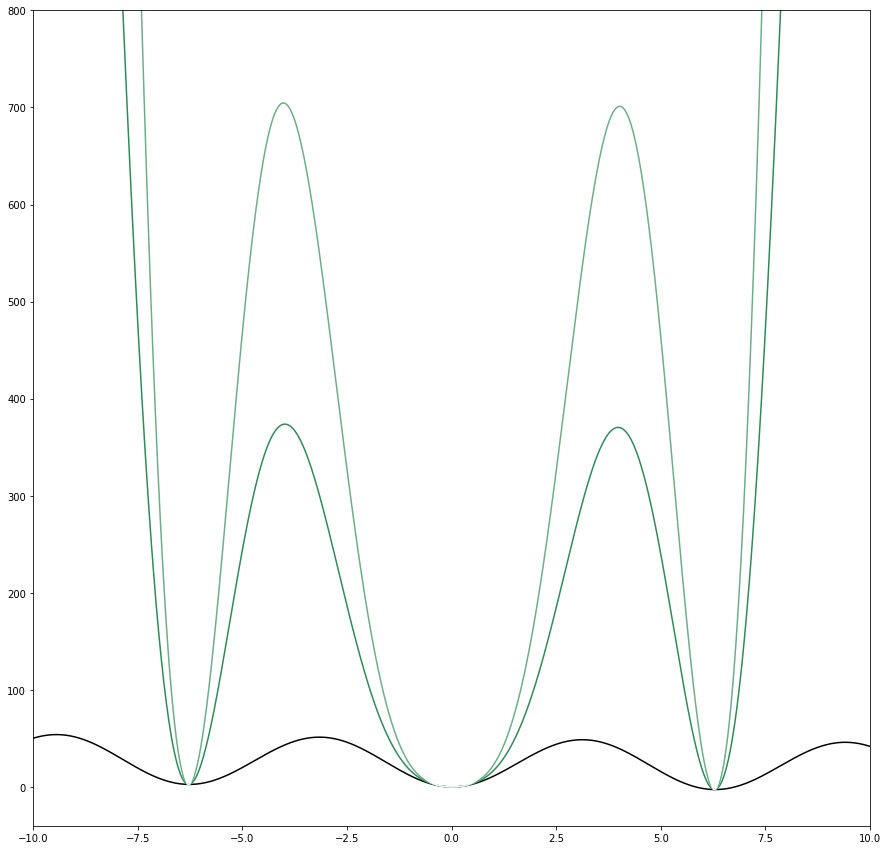

In [126]:
plt.figure(figsize=(15, 15))
plt.plot(eps, fidelity_losses, color="k", alpha=1)
plt.plot(eps, fidnorm05_losses, color="#2E8B57")
plt.plot(eps, fidnorm_losses, color="#6DAE89")
plt.plot(eps, fidnorm2_losses, color="white")

# plt.plot(eps, arccos_losses, color="k")
# plt.plot(eps, metric_losses, color="royalblue")
plt.xlim(-10, 10)
plt.ylim(-40, 800)

In [98]:
def difference(losses):
    return np.abs(np.array(metric_losses) - np.array(losses))

(1e-16, 0.1)

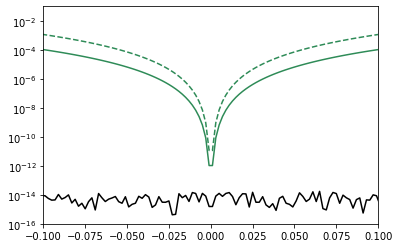

In [107]:
plt.yscale("log")
plt.plot(eps, difference(fidelity_losses), color="seagreen")
plt.plot(eps, difference(fidnorm_losses), color="seagreen", ls="--")
plt.plot(eps, difference(arccos_losses), color="k")
plt.xlim(-0.1, 0.1)
plt.ylim(1e-16, 0.1)

They have the same minimum!

### Fidelity derivatives

In [53]:
# omega = ParameterVector("omega", 10)
# ansatz = QuantumCircuit(2)
# ansatz.h([0, 1])
# ansatz.ry(omega[0], 0)
# ansatz.rx(omega[1], 1)
# ansatz.cx(0, 1)
# ansatz.rz(omega[2], 1)

ansatz = EfficientSU2(5, reps=2)
theta = np.arange(1, 1 + ansatz.num_parameters) 
direction = np.ones_like(theta)
eps = np.linspace(0, 1, num=100)
norms = [np.linalg.norm(e_i * direction) for e_i in eps]

In [54]:
def projector(ansatz, values1, values2):
    proj = Statevector.from_label("0" * ansatz.num_qubits).to_operator().data
    circuit = ansatz.bind_parameters(values1).compose(ansatz.bind_parameters(values2).inverse())
    return 1 - Statevector(circuit).expectation_value(proj) 


In [55]:
np.random.seed(1)
v1, v2 = np.random.random(ansatz.num_parameters), np.random.random(ansatz.num_parameters)
print(projector(ansatz, v1, v2))
print(infidelity(ansatz, v1, v2))

(0.623790353683237+0j)
0.6237903536832367


In [56]:
def fidelity_derivative(theta, delta_theta):
    plus = (delta_theta + np.eye(theta.size) * np.pi / 2).tolist()
    minus = (delta_theta - np.eye(theta.size) * np.pi / 2).tolist()
    
    plus_evaluated = [infidelity(ansatz, theta + p_i, theta) for p_i in plus]
    minus_evaluated = [infidelity(ansatz, theta + m_i, theta) for m_i in minus]
    
    return 0.5 * (np.array(plus_evaluated) - np.array(minus_evaluated))

In [57]:
def proj_derivative(theta, delta_theta):
    plus = (delta_theta + np.eye(theta.size) * np.pi / 2).tolist()
    minus = (delta_theta - np.eye(theta.size) * np.pi / 2).tolist()
    
    proj = np.diag([1] + [0] * (2 ** ansatz.num_qubits - 1))
    circuit = ansatz.compose(ansatz.inverse().bind_parameters(theta))
    expectations = [
        Statevector(circuit.bind_parameters(theta + v)).expectation_value(proj) 
        for v in plus + minus
    ]
    
    return -0.5 * (np.array(expectations[:theta.size]) - np.array(expectations[theta.size:]))

In [58]:
def reverse(theta, delta_theta):
    omega = ParameterVector("omega", ansatz.num_parameters)    

    circuit = ansatz.compose(ansatz.bind_parameters(theta).inverse())
#     circuit = circuit.assign_parameters([-o for o in omega])
#     print(circuit.decompose().draw())
    proj = MatrixOp(np.diag([1] + [0] * (2 ** ansatz.num_qubits - 1)))
    
    grad = ReverseGradient().compute(proj, circuit, theta + delta_theta)
    
    return -grad

In [59]:
fidelity_derivative(theta, 0.1 * direction)

array([ 0.0318112 ,  0.04013219,  0.02047304,  0.08078936,  0.03393313,
        0.05630079,  0.03233364, -0.0003866 ,  0.04863769,  0.07668085,
        0.07118305,  0.07870692,  0.0375598 ,  0.11083106,  0.08777992,
        0.00389116, -0.00556581, -0.01983639,  0.01228948,  0.0643548 ,
        0.03626312,  0.0194137 ,  0.05499488,  0.00310775,  0.00748268,
        0.02434703,  0.05470846,  0.01697823, -0.01720699,  0.00690215])

In [60]:
proj_derivative(theta, 0.1 * direction)

array([ 0.0318112 -0.j,  0.04013219-0.j,  0.02047304-0.j,  0.08078936-0.j,
        0.03393313-0.j,  0.05630079-0.j,  0.03233364-0.j, -0.0003866 +0.j,
        0.04863769-0.j,  0.07668085-0.j,  0.07118305-0.j,  0.07870692-0.j,
        0.0375598 -0.j,  0.11083106-0.j,  0.08777992-0.j,  0.00389116-0.j,
       -0.00556581+0.j, -0.01983639+0.j,  0.01228948-0.j,  0.0643548 -0.j,
        0.03626312-0.j,  0.0194137 -0.j,  0.05499488-0.j,  0.00310775-0.j,
        0.00748268-0.j,  0.02434703-0.j,  0.05470846-0.j,  0.01697823-0.j,
       -0.01720699+0.j,  0.00690215-0.j])

In [61]:
reverse(theta, 0.1 * direction)

array([ 0.0318112 ,  0.04013219,  0.02047304,  0.08078936,  0.03393313,
        0.05630079,  0.03233364, -0.0003866 ,  0.04863769,  0.07668085,
        0.07118305,  0.07870692,  0.0375598 ,  0.11083106,  0.08777992,
        0.00389116, -0.00556581, -0.01983639,  0.01228948,  0.0643548 ,
        0.03626312,  0.0194137 ,  0.05499488,  0.00310775,  0.00748268,
        0.02434703,  0.05470846,  0.01697823, -0.01720699,  0.00690215])

In [63]:
from time import time

start = time()
for _ in range(100):
    reverse(theta, 0.01 * direction)
    
print(time() - start)

7.666231870651245


In [65]:
from time import time

start = time()
for _ in range(100):
    fidelity_derivative(theta, 0.01 * direction)
    
print(time() - start)

53.17014503479004


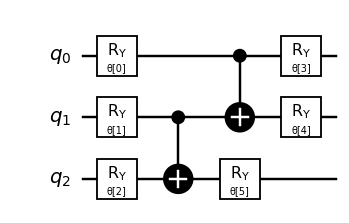

In [90]:
plt.figure()
ax = plt.axes()
RealAmplitudes(3, reps=1).decompose().draw("mpl", style="bw", ax=ax)
plt.savefig("realamp_n3_r1.pdf")

### Fidelity variance

In [251]:
A = np.array([[25]])
b = np.array([-0.5])

def f(x):
    return b.dot(x) + 0.5 * x.dot(A.dot(x))

def df(x):
    return (b + A.dot(x))

In [252]:
from qiskit.algorithms.optimizers import GradientDescent
    
gd = GradientDescent(maxiter=300, learning_rate=0.01)

In [253]:
from qiskit.algorithms.optimizers import L_BFGS_B

In [254]:
gd = L_BFGS_B()
result = gd.minimize(f, x0=np.array([0.01]))

In [255]:
print(result.fun)
print(0.5 * b.dot(result.x))

-0.004999999999999717
-0.0049999988119195414


In [234]:
losses = []
xs = []
def store_losses(*args):
    xs.append(args[1])
    losses.append(args[2])
    
gd.callback = store_losses

In [240]:
gd.minimize(f, x0=np.array([0.01]))

In [236]:
sc = [0.5 * b.dot(x_i) for x_i in xs]

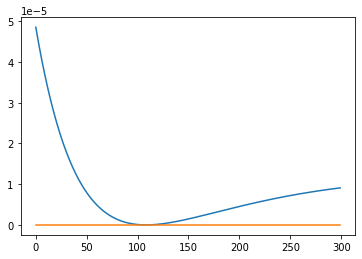

In [237]:
plt.plot(losses)
plt.plot(sc)

In [256]:
th = Parameter("th")
circuit = QuantumCircuit(1)
circuit.ry(th, 0)

H = Z
dt = 0.01

value = np.array([1])
x0 = np.array([0.01])
energy_gradient = 0.5 * ReverseGradient().compute(H, circuit, value)

qgt = ReverseQFI().compute(circuit, value) / 4

In [273]:
def fidloss(x):
    return dt * np.dot(energy_gradient, x) + 1 / 2 * infidelity(circuit, value, value + x)

In [ ]:
def df(x):
    

In [280]:
def metricloss(x):
    return dt * energy_gradient.dot(x) + 1 / 2 * x.dot(qgt.dot(x))

In [281]:
def dm(x):
    return dt * energy_gradient + qgt.dot(x)

In [282]:
def sc(x):
    return 0.5 * dt * np.dot(energy_gradient, x)

In [283]:
gd = GradientDescent(maxiter=200, learning_rate=0.1)

In [284]:
losses = []
xs = []
def store_losses(*args):
    xs.append(args[1])
    losses.append(args[2])
    
gd.callback = store_losses

In [285]:
gd.minimize(metricloss, x0, jac=dm)

In [286]:
scs = [sc(x_i) for x_i in xs]

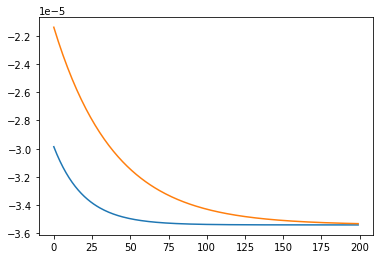

In [287]:
plt.plot(losses)
plt.plot(scs)

In [265]:
b = energy_gradient
A = qgt / dt

In [266]:
def f(x):
    return b.dot(x) + 0.5 * x.dot(A.dot(x))

def df(x):
    return (b + A.dot(x))

In [267]:
losses = []
xs = []
def store_losses(*args):
    xs.append(args[1])
    losses.append(args[2])
    
gd.callback = store_losses

In [268]:
gd.minimize(f, x0)

In [269]:
sc = [0.5 * b.dot(x_i) for x_i in xs]

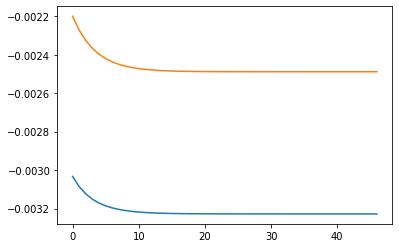

In [270]:
plt.plot(losses)
plt.plot(sc)

In [271]:
gd = L_BFGS_B()
result = gd.minimize(f, x0=np.array([0.01]))

In [272]:
print(result.fun)
print(0.5 * b.dot(result.x))

-0.0035403670913675554
-0.0035403660598565564


### Local vs global cost function